# Load Principle Components as LAE weights
* Illustrate equivalence of PCA and LAE.
* In theory LAE should be capable of finding the same weights (i.e. eigenvectors) and PCA. 

In [1]:
import keras
import keras.backend as K
import matplotlib.pyplot as plt; plt.gray()
%matplotlib inline
import numpy as np; np.random.seed(1)
import tensorflow as tf
from skimage import draw
import sys; sys.path.insert(0, "../")
import dataset

In [2]:
expl_idx = 0
vmin, vmax = -128, 128
nrows, ncols = 64, 64
nsamples = 10_000
ncomponents = 3

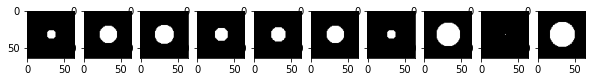

In [3]:
data = dataset.construct(nsamples, nrows, ncols, "circle")

fig, axs = plt.subplots(1, 10, figsize=(10,1))
for (i, ax) in enumerate(axs):
    ax.imshow(tf.reshape(data[i], (nrows, ncols)), vmin=0, vmax=255)

X = data - data.mean(axis=0)

### 1. Calculate eigenvectors with PCA

In [4]:
from scipy.linalg import eigh

cov = (X.T @ X) / (nsamples-1)
_, eigvecs = eigh(cov)
eigvecs = eigvecs[:, ::-1]
pcs = eigvecs[:, :ncomponents]

### 2. Load weights to LAE

In [5]:
encoder = keras.Sequential([keras.layers.Dense(units=ncomponents, input_shape=(nrows*ncols,), activation='linear', use_bias=False)])
decoder = keras.Sequential([keras.layers.Dense(units=nrows*ncols, input_shape=(ncomponents,), activation='linear', use_bias=False)])
lae = keras.Sequential([encoder, decoder])

# load eigenvectors as LAE encoder and (transposed) decoder weights
lae.layers[0].set_weights([pcs])
lae.layers[1].set_weights([pcs.T])

### 3. Evaluate LAE

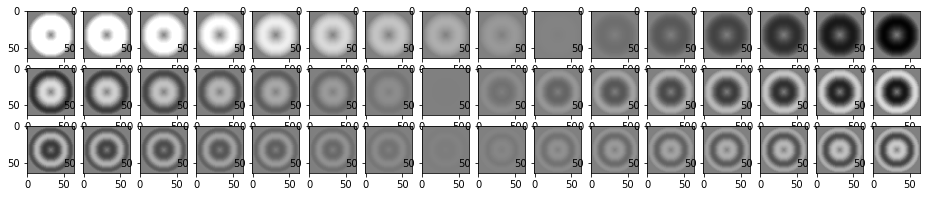

In [9]:
steps = 16
Z = encoder(X)
z_vars = [np.linspace(tf.reduce_min(z), tf.reduce_max(z), steps) for z in tf.transpose(Z)] # interpolation range

fig, axs = plt.subplots(ncols=steps, nrows=ncomponents, figsize=(steps, ncomponents))
for i in range(ncomponents):
    for j in range(steps):
        z = np.zeros_like(Z[expl_idx]) # only vary one component at a time, rest 0.
        z[i] = z_vars[i][j]
        x_pred = decoder(tf.reshape(z, (1, -1)))
        ax = list(axs.flat)[j+i*j] if ncomponents==1 else axs[i, j]
        ax.imshow(tf.reshape(x_pred,(nrows, ncols)), vmin=vmin, vmax=vmax)

Encoder weights:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Decoder weights:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
===> W_enc ?= W_dec

Dot product of all encoder weights:
 [[ 1. -0.  0.]
 [-0.  1. -0.]
 [ 0. -0.  1.]]
===> Same as PCA. Although, we see some different signs.

Cov of latent activations:
 tf.Tensor(
[[ 2.1129216e+07 -3.0339034e+00 -3.6179619e+00]
 [-3.0339034e+00  4.9682705e+06 -1.0993099e+00]
 [-3.6179619e+00 -1.0993099e+00  2.1559722e+06]], shape=(3, 3), dtype=float32)
===> Same as PCA. Although, we see differences in off-diagonal elements.


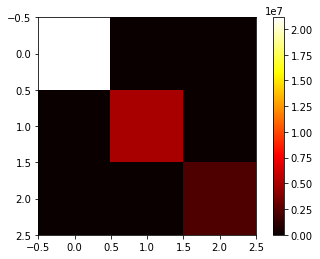

In [12]:
W_enc = np.round( lae.layers[0].get_weights()[0], 4 ).T
W_dec = np.round( lae.layers[1].get_weights()[0], 4 )

print("Encoder weights:\n", W_enc)
print("Decoder weights:\n", W_dec)
print("===> W_enc ?= W_dec\n")

pcs = encoder.weights[0]
I = (tf.transpose(pcs) @ pcs)
print("Dot product of all encoder weights:\n", np.round(I, 5))
print("===> Same as PCA. Although, we see some different signs.\n")

fig, ax = plt.subplots()
Z = tf.subtract(Z, tf.reduce_mean(Z, axis=0))
Z_cov = (tf.transpose(Z) @ Z) / (nsamples-1)
print("Cov of latent activations:\n", Z_cov)
plt.imshow(Z_cov, cmap='hot')
plt.colorbar();
print("===> Same as PCA. Although, we see differences in off-diagonal elements.")

### 4. Calculate MSE

In [7]:
X_pred = lae.predict(X)
print("MSE: ", np.square(np.subtract(X, X_pred)).mean())

MSE:  1270.472
